## Needle Search

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from random import uniform, randrange
import cv2
import math
from sympy import *

In [2]:
NEEDLE_CURVE = math.pi/4
NEEDLE_ARC_LENGTH = 300
NEEDLE_RADIUS = NEEDLE_ARC_LENGTH/NEEDLE_CURVE
TIP_TO_TIP_DISTANCE = 2*NEEDLE_RADIUS*math.sin(NEEDLE_CURVE/2)


MAX_X_EXTENSION = NEEDLE_RADIUS*cos(NEEDLE_CURVE)
MAX_Y_EXTENSION = NEEDLE_RADIUS - NEEDLE_RADIUS*sin(NEEDLE_CURVE)


In [3]:
def gen_color_map(height, width, goal_location, goal_radius):

    # create a board defaultly white
    color_map = np.full(shape=[height, width, 3], fill_value=255, dtype=np.uint8)

    # create a blue circle around the goal
    color_map = expand_goal(color_map, [0,255,255], goal_location, goal_radius, width , height)
    color_map = expand_goal(color_map, [0,0,255], goal_location, goal_radius//2, width , height)
    
    plot_obstcles(color_map)
    return color_map

In [4]:
def plot_obstcles(color_map):
    for i in range(100, 200):
        for j in range(100, 300):
            color_map[j][i] = [255, 0, 0]

    for i in range(200, 800):
        for j in range(400, 600):
            color_map[j][i] = [255, 0, 0]

    for i in range(480, 520):
        for j in range(780, 820):
            color_map[j][i] = [255, 0, 0]

In [5]:
# draw a circle (red in numpy, blue in opencv) to represent the acceptable goal zone
def expand_goal(color_map, color, goal_location, radius, width, height):

    x = goal_location[0]
    y = goal_location[1]

    goal_points = []

    # generate the range of the circle and bound check with the dimensions of the board
    x_range = range(x-radius, x+radius+1)

    for x_i in x_range:
        # we're going to effectively integrate over the x range to cover the area of the goal
        y_lower_limit = np.floor(-np.sqrt(radius**2-(x_i-x)**2) + y)
        y_upper_limit = np.ceil(np.sqrt(radius**2-(x_i-x)**2) + y)

        y_range = np.arange(y_lower_limit, y_upper_limit+1)

        for y_i in y_range:
            if (x_i >= 0 and x_i < width) and (y_i >= 0 and y_i < height):
                color_map[int(y_i)][int(x_i)] = color
                goal_points.append((int(x_i), int(y_i)))

    return color_map

In [6]:
# generate a set of points which represent points along an edge
# direction line points moves in is from point p1 to p2
def generate_line_points(p1, p2):

    x1 = p1[0]
    y1 = p1[1]

    x2 = p2[0]
    y2 = p2[1]

    points = []

    # check for the case of a vertical line
    if x1 == x2:
        if y2 > y1:
            for y in range(y1, y2+1):
                points.append((x1, y))
            return points
        else:
            for y in range(y2, y1+1):
                points.insert(0,(x1, y))
            return points

    else:
        # change the line formula to make sure the line equations are going from left to right
        # but we need to make sure that we're inserting points in the direction 
        # from the previous node to the new node
        if x2 > x1:
            
            m = (y2-y1)/(x2-x1)
            b = y1-m*x1
            lin_func = lambda x: m*x+b

            for x_i in range(x1, x2+1):
                y = lin_func(x_i)
                points.append((x_i, math.floor(y)))

            return points

        else:

            m = (y1-y2)/(x1-x2)
            b = y2-m*x2
            lin_func = lambda x: m*x+b

            for x_i in range(x2, x1+1):
                y = lin_func(x_i)
                points.insert(0,(x_i, math.floor(y)))
                
            return points


    

In [7]:
# draw the edge between two verteces on the map
def draw_edge(point1, point2, color, color_map):

    point1 = np.array(point1[:2], dtype = np.int32)
    point2 = np.array(point2[:2], dtype = np.int32)

    cv2.line(color_map, point1, point2, color ,2)        

In [8]:
def draw_path(path, color, color_map):

    if len(path) != 0:
        po = path[0]
        for pi in path[1:]:
            draw_edge(po, pi, color, color_map)
            po = pi

In [9]:
# check to see if the rgb value of the color map is [255, 0, 0]
# which is the obstacle color
def check_point_in_obstacle(point, color_map):
   y = point[1]
   x = point[0]

   # if x in range(100, 200):
   #    if y in range(100, 300):
   #       return True

   # if x in range(200, 800):
   #    if y in range(400, 600):
   #       return True
         
   # if x in range(480, 520):
   #    if y in range(700, 900):
   #       return True
         
   if color_map[int(y)][int(x)][0] == 255 and \
      color_map[int(y)][int(x)][1] == 0 and \
      color_map[int(y)][int(x)][2] == 0:
      return True

   return False

In [10]:
# pass in the set of the points from p1, the closest vertex
# to p2, the new vertex, and cut off the line if encounters an obstacle
def check_path_in_obstacle(line_points, color_map):

    if len(line_points) > 1:
        for i in range(len(line_points)):
            if check_point_in_obstacle(line_points[i], color_map):
                return line_points[:i-1]

    return line_points

In [11]:
# check to see if the rgb value of the color map is [255, 0, 0]
# which is the obstacle color
def check_point_in_solution(point, goal_location, goal_radius):
    y = point[1]
    x = point[0]

    g_x = goal_location[0]
    g_y = goal_location[1]
    
    if math.sqrt((x-g_x)**2 + (y-g_y)**2) <= goal_radius:
        return True
    else:
        return False

In [12]:
# check to see if the line is within range of the goal
def check_path_in_solution(line_points, goal_location, goal_radius):
    
    if len(line_points) > 1:
        for i in range(len(line_points)):
            if check_point_in_solution(line_points[i], goal_location, goal_radius):


                # this just is to correct some roundingerrors
                # sometimes they cause the path end location to be JUST outside of the goal. 
                # So if there is a next spot in the path, report it just so we end up in the goal
                try:
                    line_points[i+1]
                except:
                    return line_points[:i], True
                else:
                    return line_points[:i+1], True


    return line_points, False

In [13]:
# generate random samples in the continuous goal space
def generate_samples_in_goal(n_samples, goal_location, goal_radius):

    goal_samples = []

    i = 0

    while i < n_samples:

        rand_x = uniform(goal_location[0]-goal_radius, goal_location[0]+goal_radius)
        rand_y = uniform(goal_location[1]-goal_radius, goal_location[1]+goal_radius)

        rand_point = (rand_x, rand_y)

        if check_point_in_solution(rand_point, goal_location, goal_radius):
            goal_samples.append(rand_point)
            i += 1

    return goal_samples



In [14]:
# get the transformation of the point to the world frame, 
# representative of the tip of the previous needle
def gen_transformation_matrix(location):
    
    x = location[0]
    y = location[1]
    theta = location[2]


    t = Matrix([[cos(theta), -sin(theta), x], 
                [sin(theta), cos(theta) , y], 
                [0         , 0          , 1]])
    
    return t

In [15]:
# return the transformed coorinates of the point variable
#  in terms of the trnsformtion given in the t_matrix
def get_local_coord(t_matrix, global_point):

    p = Matrix(
        [[global_point[0]],
         [global_point[1]],
         [1]]
    )

    return t_matrix.pinv()*p

In [16]:
# take a point which was previously in terms of  locl fram and make them in terms of the global frame
def get_global_coord(t_matrix, local_point):

    p = Matrix(
        [[local_point[0]],
         [local_point[1]],
         [1]]
    )
    
    return t_matrix*p


In [34]:
#  uses the assumption that the needle makes up pi/4 radians of a curve length needle_length
def check_point_on_curve(localized_point):

    x = localized_point[0]
    y = localized_point[1]
    

    # calculate the difference in y values between the y value passed in with the point and the y value 
    # that would result in the point at tje given x lying on the curve
    expected_y = -math.sqrt(np.abs(NEEDLE_RADIUS**2 - x**2)) + NEEDLE_RADIUS
    localized_path = []

    abs_dist = np.abs(np.abs(y)-expected_y)

    # if the difference in y vs expected y is within a margin, then we will accept a point
    # and generate a path between the start point and end point locally
    margin = 10
    if abs_dist <= margin:
        prev_x = 0
        prev_y = 0
        for x_i in range(0, math.floor(x)):
            
            y_i = -math.sqrt(np.abs(NEEDLE_RADIUS**2 - x_i**2)) + NEEDLE_RADIUS
            theta_i = math.atan2(y_i-prev_y,x_i-prev_x)
            
            prev_x = x_i
            prev_y = y_i
            point = (x_i, y_i, theta_i)
            localized_path.append(point)


    # if the y value of the localized path is below the origin of the local frame, then just flip
    #  the sign of the y value in the path, because its mirrored about the local x path
    if y < 0:
        flipped_path = []
        for p in localized_path:
            flipped_path.append((p[0], -1*p[1], -1*p[2]))
        return flipped_path

    return localized_path

In [35]:
def get_global_path(t, local_path):

    global_path = []
    for p in local_path:
        global_point = get_global_coord(t, p)
        global_path.append((global_point[0], global_point[1]))

    return global_path

## Initialization

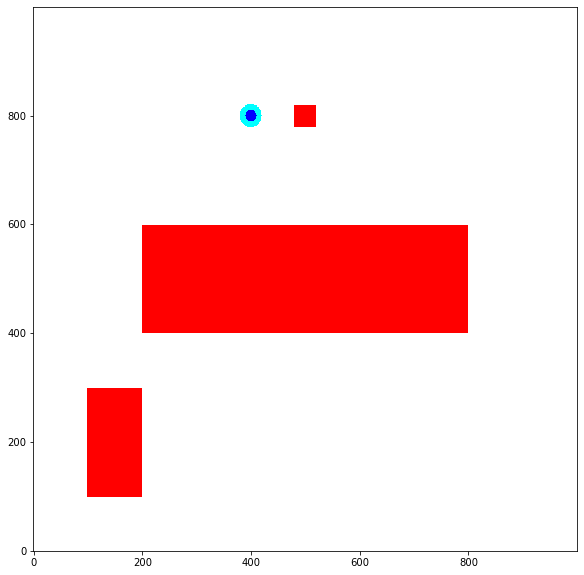

In [36]:
height = 1000
width = 1000

needle_1_len = 400

# initialize the graph
goal_location = (400, 800)
goal_radius = 20
color_map = gen_color_map(height, width, goal_location, goal_radius)


plt.figure(figsize=[10,10])
plt.imshow(color_map, origin = 'bottom')

### Check to see if we can get it in the first needle

Found Solution


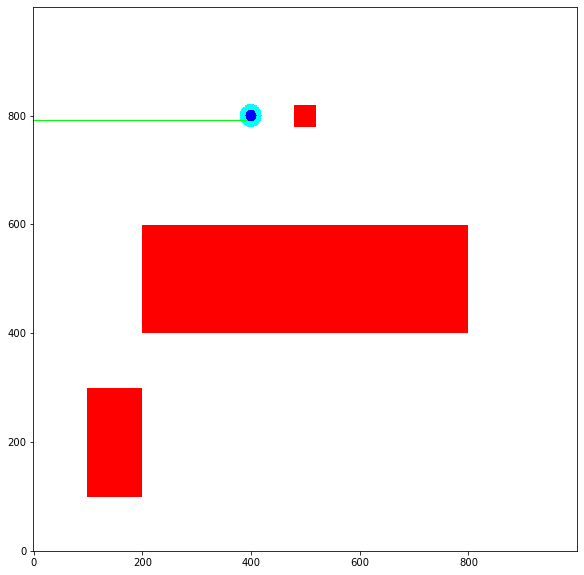

In [37]:
def check_first_needle(needle_1_len, color_map):
    
    found_solution = False

    # Iterate over the entrance pints on the left border
    # Return the first path from the entrance point to any goal point
    # within range, which is unobstructed by an obstacle
    goal_points = generate_samples_in_goal(100, goal_location, goal_radius)
    for gp in goal_points:
        gp = (int(gp[0]), int(gp[1]))

        if gp[0] < needle_1_len:

            entrance_point = [0,gp[1]]

            line_path = generate_line_points(gp, entrance_point)
            obst_path = check_path_in_obstacle(line_path, color_map)

            if len(line_path) == len(obst_path):
                print('Found Solution')
                found_solution =  True
                draw_edge(gp, entrance_point, [0,255,0], color_map)
                plt.figure(figsize=(10, 10))
                plt.imshow(color_map, origin = 'bottom')
                break

    if not found_solution:
        print('Cannot be reached within the first needle')

if goal_location[0] - goal_radius > needle_1_len:
    print('Not possible within first needle')
else:
    check_first_needle(needle_1_len, color_map)

## Re-Initialization

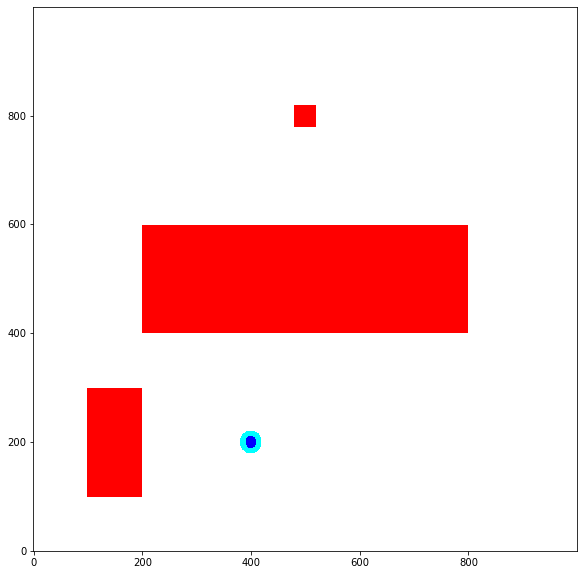

In [46]:
height = 1000
width = 1000

needle_1_len = 400
# initialize the graph
goal_location = (400, 200)
goal_radius = 20
color_map = gen_color_map(height, width, goal_location, goal_radius)

plt.figure(figsize=[10,10])
plt.imshow(color_map, origin = 'bottom')

### Check to see if we can get it in 2 needles

If we have a 2 needle success, then we know that that there is the large needle 

0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
2
3
3
4
4
4
4
5
5
5
5
6
6
6
6
7
7
7
7
8
8
8
8
8
8
9
9
10
10
10
10
10
11
11
12
13
13
14
14
14
14
14
15
15
16
16
16
17
17
18
19
19
19
19
19
19
20
20
21
21
21
21
21
21
21
22
22
22
22
22
22
22
22
22
22
23
24
24
24
24
24
24
25
25
25
25
26
26
26
26
26
26
26
26
27
27
27
27
27
27
27
27
27
28
29
30
30
30
30
30
30
30
30
31
31
31
31
31
31
31
31
31
32
32
32
33
33
33
34
34
34
34
34
34
35
35
35
35
35
36
37
37
37
37
37
37
37
37
37
37
38
39
39
40
40
40
40
41
41
42
42
43
43
43
43
43
44
44
45
45
45
45
45
45
45
45
45
46
46
46
46
46
46
46
46
46
46
47
47
47
48
48
48
48
49
50
50
50
50
50
50
50
50
51
51
51
52
52
52
52
52
52
53
53
53
54
54
54
55
56
56
56
56
57
57
57
57
57
57
57
58
58
58
58
59
59
59
60
60
61
61
61
61
62
63
64
64
64
64
64
64
64
64
65
65
65
65
65
66
66
67
67
67
67
67
68
68
68
68
68
69
70
71
71
71
71
71
72
72
72
72
73
73
73
73
73
73
73
73
73
73
73
73
73
73
73
74
74
75
76
76
76
77
78
78
78
78
79
80
80
80
80
81
81
81
81
82
83
83
83
83
84
84
85
85
85
85
86
86
87
87
88

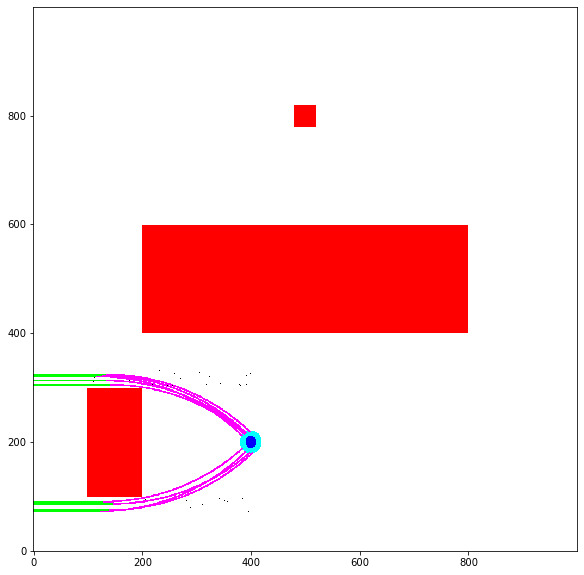

In [47]:
def second_needle_search(needle_1_len, goal_location, goal_radius, color_map):

    # search initialization
    i_limit = 100
    i = 0
    found_solution = False

    # sample the goal radius randomly
    goal_points = generate_samples_in_goal(100, goal_location, goal_radius)


    while i < i_limit:
        print(i)
        # generate randompoints in the intersection of the goal area and the first needle accessible space
        x_rand = uniform(
            max(0,(goal_location[0] - (goal_radius + MAX_X_EXTENSION))), 
            needle_1_len
            )
        y_rand = uniform(
            max(0,(goal_location[1] - (goal_radius + MAX_Y_EXTENSION))), 
            min((goal_location[1] + (goal_radius + MAX_Y_EXTENSION)), height)
            )

        # just hve an integer version so you can access the discretized map
        location = (x_rand, y_rand, 0)
        int_loc = (int(x_rand), int(y_rand))

        # if in obstacle, regen point
        if check_point_in_obstacle(int_loc, color_map):
            continue

        # check to make sure this spot is not behind an obstacle
        ep = (0, int_loc[1])
        entrant_path = generate_line_points(int_loc, ep)
        verified_entrant_path = check_path_in_obstacle(entrant_path, color_map)
        if len(entrant_path) != len(verified_entrant_path):
            continue


        # make sure that were generating points in a circular pattern
        distance = math.sqrt((x_rand-goal_location[0])**2 + (y_rand-goal_location[1])**2)
        if distance <= goal_radius + TIP_TO_TIP_DISTANCE:
        

            # plot the random connection samples
            color_map[int_loc[1]][int_loc[0]] = (0,0,0)
            t = gen_transformation_matrix(location)

            # try to connect the random connection to any of the random goal points
            for gp in goal_points:
                
                # print(f'Global coordinate of goal point: {gp}')
                # localize the goal coordinate wrt to the curve start point
                # generate local path between start and end of curve
                localized_goal_point = get_local_coord(t, gp)
                # print(f'Localized coordinate of goal point: {localized_goal_point}')
                
                # make sure that the goal point is within range of this specific mid location
                if localized_goal_point[0] > MAX_X_EXTENSION or \
                   localized_goal_point[1] > MAX_Y_EXTENSION:
                   continue

                local_path = check_point_on_curve(localized_goal_point)


                # given the local path which defines the curve, transform the points into global coordinates
                # and use those coodrinates to check if the path touches an obstacle or goal
                global_path = get_global_path(t, local_path)
                global_path = check_path_in_obstacle(global_path, color_map)
                global_path, found_solution = check_path_in_solution(global_path, goal_location, goal_radius)

                if found_solution:
                    # print(location)
                    draw_edge(ep, location, (0,255,0), color_map)
                    draw_path(global_path, (255,0,255), color_map)
                    found_solution = True
                    # break
                    # return

            i += 1

    if not found_solution:
        print("No solution found")


if goal_location[0] - (goal_radius+TIP_TO_TIP_DISTANCE) > needle_1_len:
    print('Not possible within 2 needles')
else:
    second_needle_search(needle_1_len, goal_location, goal_radius, color_map)
    plt.figure(figsize=(10,10))
    plt.imshow(color_map, origin='bottom')

### 3 needle search

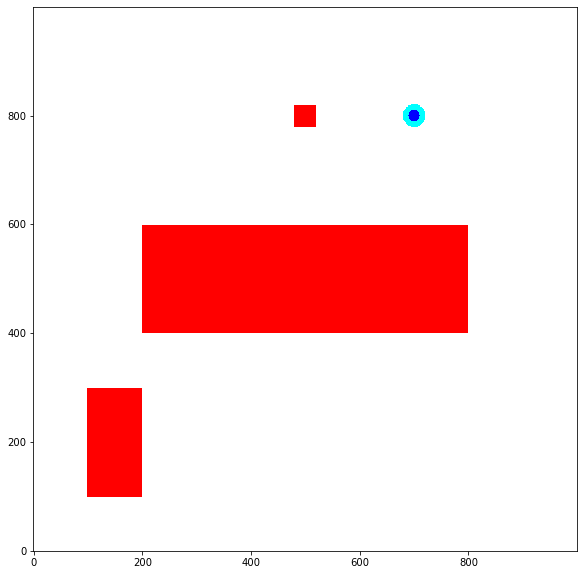

In [57]:
height = 1000
width = 1000

needle_1_len = 400
goal_location = (700,800)
goal_radius = 20
color_map = gen_color_map(height, width, goal_location, goal_radius)


plt.figure(figsize=[10,10])
plt.imshow(color_map, origin = 'bottom')

(174.285224094393, 714.6815018659306, 0)
0:0
0:1
0:2
0:3
0:4
0:5
0:6
0:7
0:8
(174.285224094393, 714.6815018659306, 0)
(429.285224094393, 812.263660049165, 0.7292096369808976)
0:9
0:10
0:11
0:12
0:13
0:14
0:15
0:16
0:17
0:18
0:19
0:20
0:21
0:22
0:23
(174.285224094393, 714.6815018659306, 0)
(433.285224094393, 815.901687740349, 0.7433425212862613)
0:24
0:25
0:26
(174.285224094393, 714.6815018659306, 0)
(441.285224094393, 823.498639087268, 0.7721770751852345)
0:27
0:28
0:29
0:30
0:31
0:32
0:33
0:34
(174.285224094393, 714.6815018659306, 0)
(431.285224094393, 814.069741477586, 0.7362534515499819)
0:35
(174.285224094393, 714.6815018659306, 0)
(433.285224094393, 815.901687740349, 0.7433425212862613)
0:36
0:37
0:38
0:39
0:40
0:41
0:42
0:43
0:44
0:45
0:46
0:47
0:48
0:49
0:50
(174.285224094393, 714.6815018659306, 0)
(434.285224094393, 816.827518651530, 0.7469044145651231)
0:51
0:52
0:53
0:54
0:55
0:56
0:57
0:58
0:59
0:60
0:61
0:62
0:63
0:64
0:65
0:66
0:67
0:68
0:69
0:70
(174.285224094393, 714.681

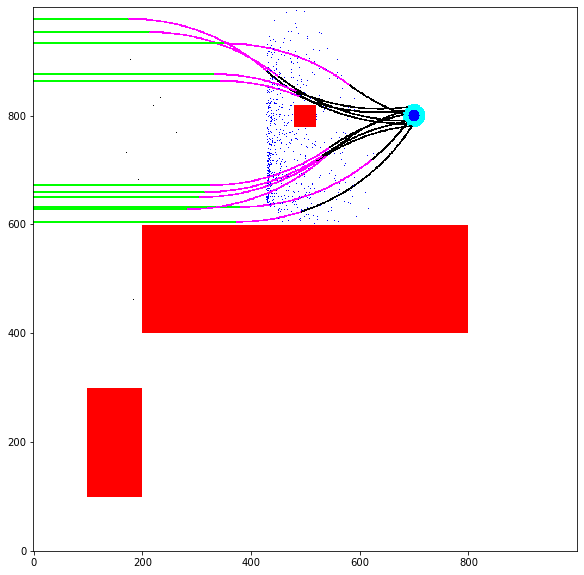

In [62]:
def third_needle_search(needle_1_len, goal_location, goal_radius, color_map):

    # search initialization
    i_limit = 100
    i = 0
    found_solution = False

    # sample the goal radius randomly
    goal_points = generate_samples_in_goal(100, goal_location, goal_radius)


    while i < i_limit:

        # generate randompoints in the intersection of the first and second needle
        x_rand = uniform(
            max(0,(goal_location[0] - (2*MAX_X_EXTENSION))), 
            needle_1_len
            )
        y_rand = uniform(
            max(0, (goal_location[1]-(NEEDLE_RADIUS))),
            min((goal_location[1] + (NEEDLE_RADIUS)), height)
        )

        # just hve an integer version so you can access the discretized map
        mid_location = (x_rand, y_rand, 0)
        int_mid_loc = (int(x_rand), int(y_rand))

        # if in obstacle, regen point
        if check_point_in_obstacle(int_mid_loc, color_map):
            continue

        # check to make sure this spot is not behind an obstacle
        ep = (0, int_mid_loc[1])
        entrant_path = generate_line_points(int_mid_loc, ep)
        verified_entrant_path = check_path_in_obstacle(entrant_path, color_map)
        if len(entrant_path) != len(verified_entrant_path):
            continue


        color_map[int_mid_loc[1]][int_mid_loc[0]] = (0,0,0)
        t = gen_transformation_matrix(mid_location)

        j = 0
        j_limit = 100

        print(mid_location)
        while j < j_limit:

            # generate randompoints in the intersection of the second and third needle
            x_rand = uniform(
                max(goal_location[0] - MAX_X_EXTENSION, mid_location[0]),
                min(goal_location[0], mid_location[0] + MAX_X_EXTENSION)
            )

            y_rand = uniform(
                max(0, goal_location[1]-MAX_X_EXTENSION),
                min(goal_location[1] + MAX_X_EXTENSION, height)
            )


            inner_loc = (x_rand, y_rand)
            int_inner_loc = (int(x_rand), int(y_rand))

            if check_point_in_obstacle(int_inner_loc, color_map):
                continue
            

            distance_from_goal = math.sqrt((x_rand-goal_location[0])**2 + (y_rand-goal_location[1])**2)
            if distance_from_goal >= (goal_radius + TIP_TO_TIP_DISTANCE):
                continue

            # localize the goal coordinate wrt to the curve start point
            # generate local path between start and end of curve
            localized_inner_point = get_local_coord(t, inner_loc)
            if localized_inner_point[0] > MAX_X_EXTENSION or \
                localized_inner_point[1] > MAX_Y_EXTENSION:
                continue        


            local_inner_path = check_point_on_curve(localized_inner_point)
            print(f"{i}:{j}")

            color_map[int_inner_loc[1]][int_inner_loc[0]] = (0,0,255)
            j += 1  

            # this checks to make sure that we've actually made a connection
            if local_inner_path is None or len(local_inner_path) == 0:
                continue
            


            global_inner_path = get_global_path(t, local_inner_path)
            verified_inner_path = check_path_in_obstacle(global_inner_path, color_map)

            # if we've hit an obstacle then skip this path
            if(len(verified_inner_path) != len(global_inner_path)):
                continue

            global_inner_connection = (global_inner_path[-1][0], global_inner_path[-1][1], local_inner_path[-1][2])
            print(mid_location)
            print(global_inner_connection)

            inner_t = gen_transformation_matrix(global_inner_connection)

            # try to connect the random connection to any of the random goal points
            for gp in goal_points:
                
                # print(f'Global coordinate of goal point: {gp}')
                # localize the goal coordinate wrt to the curve start point
                # generate local path between start and end of curve
                localized_goal_point = get_local_coord(inner_t, gp)
                # print(f'Localized coordinate of goal point: {localized_goal_point}')
                
                # make sure that the goal point is within range of this specific mid location
                if localized_goal_point[0] > MAX_X_EXTENSION or \
                   localized_goal_point[1] > MAX_Y_EXTENSION:
                   continue

                local_path = check_point_on_curve(localized_goal_point)


                # given the local path which defines the curve, transform the points into global coordinates
                # and use those coodrinates to check if the path touches an obstacle or goal
                global_path = get_global_path(inner_t, local_path)
                verified_global_path = check_path_in_obstacle(global_path, color_map)
                if(len(verified_global_path) != len(global_path)):
                    continue
                global_path, found_solution = check_path_in_solution(global_path, goal_location, goal_radius)

                if found_solution:
                    # print(location)
                    draw_edge(ep, mid_location, (0,255,0), color_map)
                    draw_path(global_inner_path, (255,0,255), color_map)
                    draw_path(global_path, (0,0,0), color_map)
                    found_solution = True
                    # break
                    return mid_location, global_inner_path, global_path


            
        i += 1

    if not found_solution:
        print("No solution found")


# if goal_location[0] - (goal_radius+2*TIP_TO_TIP_DISTANCE) > needle_1_len:
#     print('Not possible within 2 needles')
# else:
for i in range(5):
    mid_location, inner_path, goal_path = third_needle_search(needle_1_len, goal_location, goal_radius, color_map)
plt.figure(figsize=(10,10))
plt.imshow(color_map, origin='bottom')

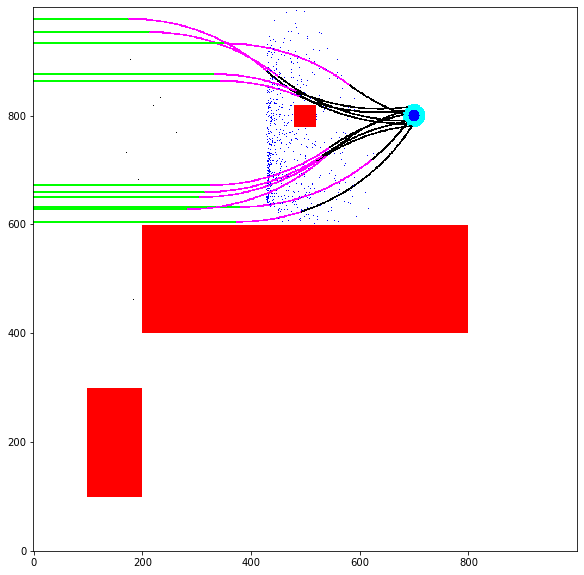

In [63]:
plt.figure(figsize=(10,10))
plt.imshow(color_map, origin='bottom')